<a href="https://colab.research.google.com/github/tiwausman/fastbook/blob/master/Copy_of_efficientnetb4(EX)(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install focal-loss

In [ ]:
"""
Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf
Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)
Note: Batch normalization should be performed over channels after a convolution,
In the following code axis is set to 3 as our inputs are of shape
[None, height, width, channel]. Channel is axis=3.
Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:

import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = '/content/drive/MyDrive/retinaseg/train/image/'
mask_directory = '/content/drive/MyDrive/retinaseg/train/mask/'


SIZE = 512
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'jpg'):
        print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name,1)

        size = (SIZE, SIZE)

        # Extract the green channel
        green_channel = image[:,:,1]

        # Apply histogram equalization
        equalized = cv2.equalizeHist(green_channel)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_output = clahe.apply(green_channel)

        # Resize the image SIZES bicubic interpolation
        resized_img = cv2.resize(clahe_output, size, interpolation=cv2.INTER_CUBIC)

        image_dataset.append(np.array(resized_img))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        print(mask_directory+image_name)
        image = cv2.imread(mask_directory+image_name,0)

        size = (SIZE, SIZE)

        # Resize the image SIZES bicubic interpolation
        resized_img = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)
        mask_dataset.append(np.array(resized_img))


#Normalize images
image_dataset = np.stack((image_dataset,)*3, axis=-1)
image_dataset = np.array(image_dataset)/255.
print(1)
#D not normalize masks, just rescale to 0 to 1.
# Calculate the mean value of the image
mean_value = np.mean(image_dataset)
print(2)


print(3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
mask_dataset = np.round(mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)
print("Pixel values in the mask are: ", np.unique(mask_dataset))

/content/drive/MyDrive/retinaseg/train/image/01_test.jpg
/content/drive/MyDrive/retinaseg/train/image/02_test.jpg
/content/drive/MyDrive/retinaseg/train/image/03_test.jpg
/content/drive/MyDrive/retinaseg/train/image/04_test.jpg
/content/drive/MyDrive/retinaseg/train/image/05_test.jpg
/content/drive/MyDrive/retinaseg/train/image/06_test.jpg
/content/drive/MyDrive/retinaseg/train/image/07_test.jpg
/content/drive/MyDrive/retinaseg/train/image/08_test.jpg
/content/drive/MyDrive/retinaseg/train/image/09_test.jpg
/content/drive/MyDrive/retinaseg/train/image/10_test.jpg
/content/drive/MyDrive/retinaseg/train/image/11_test.jpg
/content/drive/MyDrive/retinaseg/train/image/12_test.jpg
/content/drive/MyDrive/retinaseg/train/image/13_test.jpg
/content/drive/MyDrive/retinaseg/train/image/14_test.jpg
/content/drive/MyDrive/retinaseg/train/image/15_test.jpg
/content/drive/MyDrive/retinaseg/train/image/16_test.jpg
/content/drive/MyDrive/retinaseg/train/image/17_test.jpg
/content/drive/MyDrive/retinase

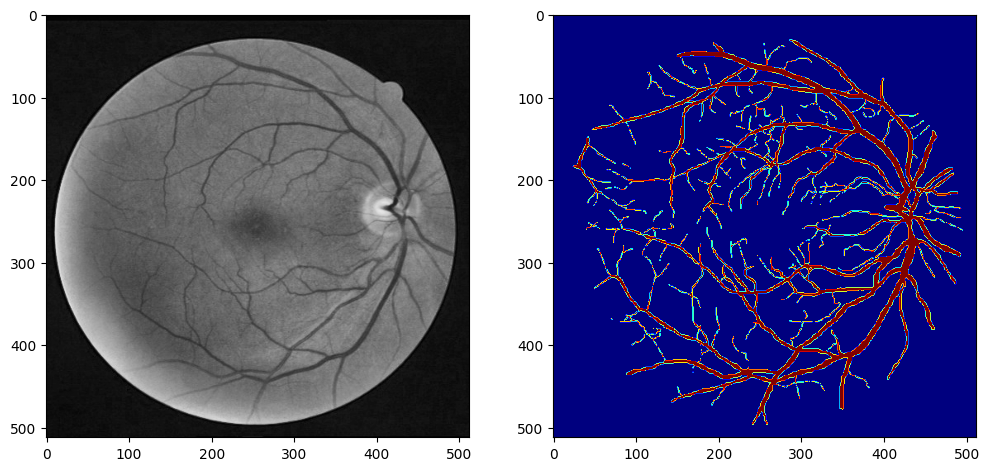

In [ ]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='jet')
plt.show()

#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 4

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

In [ ]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Lambda ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def gating_signal(input, out_size, batch_norm=True):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def res_conv_block(x, filter_size, size, dropout=0.5, batch_norm=True):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path
def decoder_block(input, skip_features, FILTER_NUM):
   # network structure

    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    gating = gating_signal(input, FILTER_NUM)
    att = attention_block(skip_features, gating, FILTER_NUM)
    up = SubpixelUpsampling(input, skip_features)
    print(up.shape, att.shape)
    up = layers.concatenate([up, att], axis=3)
    up_conv = conv_block(up,FILTER_NUM)
    return up_conv
def decoder2(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
def SubpixelUpsampling(x, y):
    depth = tf.keras.backend.int_shape(x)[-1]
    def depth_to_space(x):
          return tf.nn.depth_to_space(x, 2)
    x = Conv2D(filters=depth*2, kernel_size=(1,1), strides=1, padding='same', )(x)
    x = Lambda(depth_to_space)(x)
    x = concatenate([x, y])
    return x

def build_effienet_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB4(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output                      ## 256
    s2 = encoder.get_layer("block2a_expand_activation").output    ## 128
    s3 = encoder.get_layer("block3a_expand_activation").output    ## 64
    s4 = encoder.get_layer("block4a_expand_activation").output    ## 32

    """ Bottleneck """
    b1 = encoder.get_layer("block6a_expand_activation").output    ## 16

    """ Decoder """
    d1 = SubpixelUpsampling(b1, s4)
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = SubpixelUpsampling(d1, s3,)
    d2 = decoder_block(d1, s3, 256)                    ## (128 x 128)
    d3 = SubpixelUpsampling(d2, s2,)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = SubpixelUpsampling(d3, s1, )
    d4 = decoder_block(d3, s1, 64)
    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    return model


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE2 = 'resnet50'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [ ]:
X_train2.shape

(32, 512, 512, 3)

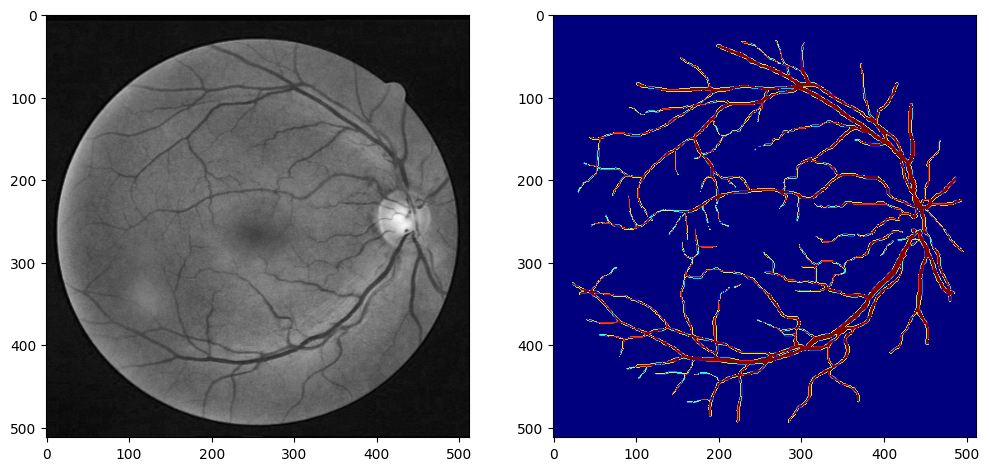

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train2))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train2[image_number], (SIZE, SIZE, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='jet')
plt.show()

In [ ]:

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
from keras.preprocessing.image import ImageDataGenerator
img_data_gen_args = dict(
    rotation_range=10,
    zoom_range=(1.0, 1.1),
    vertical_flip=True,
    horizontal_flip=True,)

mask_data_gen_args = dict(
    rotation_range=10,
    zoom_range=(1.0, 1.1),
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype))

In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test2, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

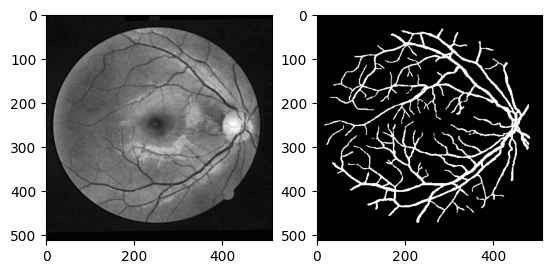

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

In [ ]:
import tensorflow.keras.backend as K

def weighted_binary_crossentropy(y_true, y_pred):
    # Define the class weights
    class_weights = K.variable([0.01, 0.99])  # assuming the background class is more prevalent

    # Calculate the weighted binary cross-entropy loss
    b_ce = K.binary_crossentropy(y_true, y_pred)
    w_b_ce = K.mean(class_weights * b_ce)

    return w_b_ce


from focal_loss import BinaryFocalLoss

In [ ]:
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:

build_resnet50_unet_model = build_effienet_unet(input_shape)
build_resnet50_unet_model.compile(optimizer=Adam(lr = 1e-4), loss=total_loss,
              metrics=metrics)


print(build_resnet50_unet_model.summary())


71686520/71686520 [==============================] - 4s 0us/step
(None, 64, 64, 816) (None, 64, 64, 336)
(None, 128, 128, 448) (None, 128, 128, 192)
(None, 256, 256, 272) (None, 256, 256, 144)


(None, 512, 512, 67) (None, 512, 512, 3)
Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 512, 512, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 512

In [ ]:
print(tf. __version__)

2.13.0


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopping = EarlyStopping(
  monitor='val_loss',
  min_delta=0,
  patience=10,
  verbose=1,
  restore_best_weights=True)

reducelr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.1,
  patience=3,
  verbose=1,
  min_delta=0.0001 )

callbacks = [earlystopping, reducelr]
steps_per_epoch = 3*(len(X_train))//batch_size

In [ ]:
start1 = datetime.now()
build_resnet50_unet_history = build_resnet50_unet_model.fit(X_train2, y_train , validation_data=(X_test2, y_test),batch_size = 4,verbose=1,
                    shuffle=False,
                    epochs=200,)


stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)


# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd
build_resnet50_unet_history_df = pd.DataFrame(build_resnet50_unet_history.history)
with open('resnet50_unet_history_df4.csv', mode='w') as f:
    build_resnet50_unet_history_df.to_csv(f)

Epoch 1/200
8/8 [==============================] - 148s 2s/step - loss: 0.7157 - iou_score: 0.4012 - f1-score: 0.5524 - val_loss: 0.9147 - val_iou_score: 5.8861e-06 - val_f1-score: 1.1772e-05
Epoch 2/200
8/8 [==============================] - 13s 2s/step - loss: 0.4820 - iou_score: 0.6003 - f1-score: 0.7500 - val_loss: 0.9887 - val_iou_score: 4.7049e-04 - val_f1-score: 9.4053e-04
Epoch 3/200
8/8 [==============================] - 13s 2s/step - loss: 0.3946 - iou_score: 0.6346 - f1-score: 0.7764 - val_loss: 4.9370 - val_iou_score: 0.0838 - val_f1-score: 0.1547
Epoch 4/200
8/8 [==============================] - 12s 2s/step - loss: 0.3532 - iou_score: 0.6511 - f1-score: 0.7887 - val_loss: 1.3290 - val_iou_score: 0.0855 - val_f1-score: 0.1576
Epoch 5/200
8/8 [==============================] - 12s 2s/step - loss: 0.3305 - iou_score: 0.6562 - f1-score: 0.7923 - val_loss: 0.9069 - val_iou_score: 3.0987e-05 - val_f1-score: 6.1971e-05
Epoch 6/200
8/8 [==============================] - 13s 2s/st

In [ ]:

###
#plot the training and validation accuracy and loss at each epoch

history = build_resnet50_unet_history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score


from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn import metrics
#Load one model at a time for testing.
model =build_resnet50_unet_model


import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    print(IoU)
    if IoU >= 0.5:
      # Calculate metrics
      accuracy = accuracy_score(ground_truth[:,:,0].flatten(), prediction.flatten())
      precision = precision_score(ground_truth[:,:,0].flatten(), prediction.flatten())
      sensitivity = recall_score(ground_truth[:,:,0].flatten(), prediction.flatten())
      recall = recall_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
      f1 = f1_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
      true_negatives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 0))
      false_positives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 1))
      specificity = true_negatives / (true_negatives + false_positives)

      ground_truth_flat = ground_truth[:,:,0].flatten()
      prediction_flat = prediction.flatten()

      precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
      aupr = auc(recall, precision)
      aupr_values.append(aupr)
      # Calculate the false positive rate (fpr) and true positive rate (tpr)
      fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

      # Calculate the Area Under the Curve (AUC)
      auc_ = metrics.auc(fpr, tpr)

      IoU_values.append(IoU)

      accuracy_values.append(accuracy)
      precision_values.append(precision)
      sensitivity_values.append(sensitivity)
      f1_score_values.append(f1)
      specificity_values.append(specificity)
      recall_values.append(recall)
      auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

from keras.models import load_model

#Load one model at a time for testing.
model = load_model('/content/drive/MyDrive/retinaseg/DenseNet121.hdf5', compile=False)


import random
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    print(IoU)
    # Calculate metrics
    accuracy = accuracy_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    precision = precision_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    sensitivity = recall_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    recall = recall_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 0))
    false_positives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)

    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = prediction.flatten()

    precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
    aupr = auc(recall, precision)
    aupr_values.append(aupr)
    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc_ = metrics.auc(fpr, tpr)

    IoU_values.append(IoU)

    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_values.append(recall)
    auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

from keras.models import load_model

#Load one model at a time for testing.
model = load_model('/content/drive/MyDrive/retinaseg/resnet50.hdf5', compile=False)


import random
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    print(IoU)
    # Calculate metrics
    accuracy = accuracy_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    precision = precision_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    sensitivity = recall_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    recall = recall_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 0))
    false_positives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)

    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = prediction.flatten()

    precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
    aupr = auc(recall, precision)
    aupr_values.append(aupr)
    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc_ = metrics.auc(fpr, tpr)

    IoU_values.append(IoU)

    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_values.append(recall)
    auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

from keras.models import load_model

#Load one model at a time for testing.
model = load_model('/content/drive/MyDrive/retinaseg/VGG16.hdf5', compile=False)


import random
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    print(IoU)
    # Calculate metrics
    accuracy = accuracy_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    precision = precision_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    sensitivity = recall_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    recall = recall_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 0))
    false_positives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)

    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = prediction.flatten()

    precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
    aupr = auc(recall, precision)
    aupr_values.append(aupr)
    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc_ = metrics.auc(fpr, tpr)

    IoU_values.append(IoU)

    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_values.append(recall)
    auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

from keras.models import load_model

#Load one model at a time for testing.
model = load_model('/content/drive/MyDrive/retinaseg/InceptionResNetV2.hdf5', compile=False)


import random
test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(temp_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    print(IoU)
    # Calculate metrics
    accuracy = accuracy_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    precision = precision_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    sensitivity = recall_score(ground_truth[:,:,0].flatten(), prediction.flatten())
    recall = recall_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:,:,0], prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 0))
    false_positives = np.sum((ground_truth[:,:,0] == 0) & (prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)

    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = prediction.flatten()

    precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
    aupr = auc(recall, precision)
    aupr_values.append(aupr)
    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc_ = metrics.auc(fpr, tpr)

    IoU_values.append(IoU)

    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_values.append(recall)
    auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)

In [ ]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Lambda ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K

test_img_number = 3
model2 = load_model('/content/drive/MyDrive/retinaseg/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/retinaseg/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/retinaseg/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/retinaseg/InceptionResNetV2.hdf5', compile=False)
#Weighted average ensemble

#Weighted average ensemble
models = [ model2, model3, model4, model5]
prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

preds=np.array([ prediction2, prediction3, prediction4, prediction5])
print(preds.shape)
#preds=np.array(preds)
weights = [0.4, 0.2, 0.2,0.2,]
threshold = 0.5
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_prediction, cmap='gray')

plt.show()
n_classes = 2
IOU_keras2 = MeanIoU(num_classes=n_classes)
IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
print("Mean IoU2=", IOU_keras2.result().numpy())
IOU_keras3 = MeanIoU(num_classes=n_classes)
IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
print("Mean IoU3 =", IOU_keras3.result().numpy())
IOU_keras4 = MeanIoU(num_classes=n_classes)
IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
print("Mean IoU4 =", IOU_keras4.result().numpy())
IOU_keras5 = MeanIoU(num_classes=n_classes)
IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
print("Mean IoU5 =", IOU_keras5.result().numpy())
IOU_kerasW = MeanIoU(num_classes=n_classes)
IOU_kerasW.update_state(ground_truth[:,:,0], weighted_ensemble_prediction)
print("Mean IoUW =", IOU_kerasW.result().numpy())

In [ ]:

import pandas as pd
df = pd.DataFrame([])
for w1 in range(0,4):
  for w2 in range(0, 4):
    for w3 in range(0,4):
        for w4 in range(0,4):
            wts = [w1/10.,w2/10.,w3/10.,w4/10.,]

            IOU_wted = MeanIoU(num_classes=n_classes)
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            print(preds.shape)
            wted_ensemble_pred = (wted_preds > threshold).astype(np.uint8)
            IOU_wted.update_state(ground_truth[:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                          'wt3':wts[2],'wt4':wts[3], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)

max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2], " and w4=", max_iou_row[3])


In [ ]:
max_iou_row = df.loc[df['IOU'].idxmax()]
max_iou_row

In [ ]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Lambda ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K

model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/important retinafiles(EX)/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/important retinafiles(EX)/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/important retinafiles(EX)/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/important retinafiles(EX)/InceptionResNetV2.hdf5', compile=False)
#Weighted average ensemble

#Weighted average ensemble
models = [model1, model2, model3, model4, model5]
#preds = [model.predict(X_test) for model in models]

pred1 = model1.predict(X_test2> 0.5).astype(np.uint8)
pred2 = model2.predict(X_test2> 0.5).astype(np.uint8)
pred3 = model3.predict(X_test2> 0.5).astype(np.uint8)
pred4 = model4.predict(X_test2> 0.5).astype(np.uint8)
pred5 = model5.predict(X_test2> 0.5).astype(np.uint8)

preds=np.array([pred1, pred2, pred3, pred4, pred5])
print(preds.shape)
#preds=np.array(preds)
weights = [0.1, 0.2, 0.3,0.1,0.1]
threshold = 0.2
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = (weighted_preds > threshold).astype(np.uint8)



#Using built in keras function
n_classes = 2
IOU1 = MeanIoU(num_classes=n_classes)
IOU2 = MeanIoU(num_classes=n_classes)
IOU3 = MeanIoU(num_classes=n_classes)
IOU4 = MeanIoU(num_classes=n_classes)
IOU5 = MeanIoU(num_classes=n_classes)
IOU_weighted = MeanIoU(num_classes=n_classes)

IOU1.update_state(y_test[:,:,:,0], pred1)
IOU2.update_state(y_test[:,:,:,0], pred2)
IOU3.update_state(y_test[:,:,:,0], pred3)

IOU4.update_state(y_test[:,:,:,0], pred4)
IOU5.update_state(y_test[:,:,:,0], pred5)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)

print("Pixel values in the y_test are: ", np.unique(y_test))

print("Pixel values in the weighted_ensemble_prediction are: ", np.unique(weighted_ensemble_prediction))
# Calculate metrics
accuracy = accuracy_score(y_test[:,:,:,0].flatten(), weighted_ensemble_prediction.flatten())
precision = precision_score(y_test[:,:,:,0].flatten(), weighted_ensemble_prediction.flatten())
sensitivity = recall_score(y_test[:,:,:,0].flatten(), weighted_ensemble_prediction.flatten())




print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for model4 = ', IOU4.result().numpy())
print('IOU Score for model5 = ', IOU5.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print()

In [ ]:
"""
import pandas as pd
df = pd.DataFrame([])
for w1 in range(0,10):
  for w2 in range(0, 10):
    for w3 in range(0,10):
        for w4 in range(0,10):
          for w5 in range(0,10):
            wts = [w1/10.,w2/10.,w3/10.,w4/10.,w5/10.,]

            IOU_wted = MeanIoU(num_classes=n_classes)
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = (wted_preds > threshold).astype(np.uint8)
            IOU_wted.update_state(ground_truth[:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10.,  w4/10.,w5/10., " : IOU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                          'wt3':wts[2],'wt4':wts[3],'wt5':wts[4], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)

max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2], " and w4=", max_iou_row[3])
"""

In [ ]:
df

In [ ]:
max_iou_row = df.loc[df['IOU'].idxmax()]
max_iou_row

In [ ]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Lambda ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K

test_img_number = 4
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/important retinafiles(EX)/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/important retinafiles(EX)/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/important retinafiles(EX)/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/important retinafiles(EX)/InceptionResNetV2.hdf5', compile=False)
#Weighted average ensemble
#Weighted average ensemble

#Weighted average ensemble
models = [ model1, model2, model3, model4, model5]
prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

preds=np.array([ prediction1,prediction2, prediction3, prediction4, prediction5])
print(preds.shape)
#preds=np.array(preds)
weights = [0.2, 0.2, 0.2,0.2,0.]
threshold = 0.3
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_prediction, cmap='gray')

plt.show()
n_classes = 2
IOU_keras1 = MeanIoU(num_classes=n_classes)
IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
print("Mean IoU1=", IOU_keras1.result().numpy())
IOU_keras2 = MeanIoU(num_classes=n_classes)
IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
print("Mean IoU2=", IOU_keras2.result().numpy())
IOU_keras3 = MeanIoU(num_classes=n_classes)
IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
print("Mean IoU3 =", IOU_keras3.result().numpy())
IOU_keras4 = MeanIoU(num_classes=n_classes)
IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
print("Mean IoU4 =", IOU_keras4.result().numpy())
IOU_keras5 = MeanIoU(num_classes=n_classes)
IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
print("Mean IoU5 =", IOU_keras5.result().numpy())
IOU_kerasW = MeanIoU(num_classes=n_classes)
IOU_kerasW.update_state(ground_truth[:,:,0], weighted_ensemble_prediction)
print("Mean IoUW =", IOU_kerasW.result().numpy())

accuracy = accuracy_score(ground_truth[:,:,0], weighted_ensemble_prediction)
precision = precision_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted')
sensitivity = recall_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print()

In [ ]:
#Calculate IoU for all test images and average

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

# Loop through all images in X_test
IoU1_values = []
IoU2_values = []
IoU3_values = []
IoU4_values = []
IoU5_values = []
IoUW_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_vaules = []
auc_values = []
model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/retinaseg/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/retinaseg/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/retinaseg/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/retinaseg/InceptionResNetV2.hdf5', compile=False)
models = [ model1, model2, model3, model4, model5]
for img in range(0, image_dataset.shape[0]):
    test_img = image_dataset[img]
    ground_truth=mask_dataset[img]
    test_img_norm=test_img[:,:,:]
    test_img_input=np.expand_dims(test_img_norm, 0)


    #Weighted average ensemble

    #Weighted average ensemble

    prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    preds=np.array([ prediction1,prediction2, prediction3, prediction4, prediction5])
    print(preds.shape)
    #preds=np.array(preds)
    weights = [0.1, 0.1, 0.1,0.1,0.0]
    threshold = 0.3
    weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(weighted_ensemble_prediction, cmap='gray')

    plt.show()
    n_classes = 2
    IOU_keras1 = MeanIoU(num_classes=n_classes)
    IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
    IOU1 = IOU_keras1.result().numpy()
    print("IoU1=", IOU1)
    IOU_keras2 = MeanIoU(num_classes=n_classes)
    IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
    IOU2 = IOU_keras2.result().numpy()
    print("IoU2=", IOU2)
    IOU_keras3 = MeanIoU(num_classes=n_classes)
    IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
    IOU3 = IOU_keras3.result().numpy()
    print("IoU3 =", IOU3)
    IOU_keras4 = MeanIoU(num_classes=n_classes)
    IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
    IOU4 = IOU_keras4.result().numpy()
    print("IoU4 =", IOU4)
    IOU_keras5 = MeanIoU(num_classes=n_classes)
    IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
    IOU5 = IOU_keras5.result().numpy()
    print("IoU5 =", IOU5)
    IOU_kerasW = MeanIoU(num_classes=n_classes)
    IOU_kerasW.update_state(ground_truth[:,:,0], weighted_ensemble_prediction)
    IOUW = IOU_kerasW.result().numpy()
    print("IoUW =", IOUW)

    accuracy = accuracy_score(ground_truth[:,:,0], weighted_ensemble_prediction)
    precision = precision_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    sensitivity = recall_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    recall = recall_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 0))
    false_positives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)
    # Flatten the ground truth and prediction arrays
    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = weighted_ensemble_prediction.flatten()

    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc = metrics.auc(fpr, tpr)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Specificity:", specificity)
    print("AUC:", auc)
    IoU1_values.append(IOU1)
    IoU2_values.append(IOU2)
    IoU3_values.append(IOU3)
    IoU4_values.append(IOU4)
    IoU5_values.append(IOU5)
    IoUW_values.append(IOUW)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_vaules.append(recall)
    auc_values.append(auc)
# ...

# Create a dataframe with the IoU, accuracy, precision, and sensitivity values
df = pd.DataFrame({
    "IoU1": IoU1_values,
    "IoU2": IoU2_values,
    "IoU3": IoU3_values,
    "IoU4": IoU4_values,
    "IoU5": IoU5_values,
    "IoUW": IoUW_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_vaules,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC":auc_values
})



mean_IoU1 = df["IoU1"].mean()
mean_IoU2 = df["IoU2"].mean()
mean_IoU3 = df["IoU3"].mean()
mean_IoU4 = df["IoU4"].mean()
mean_IoU5 = df["IoU5"].mean()
mean_IoUW = df["IoUW"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_Recall = df["Recall"].mean()
mean_F1 = df["F1 Score"].mean()
mean_Specificity= df["Specificity"].mean()
mean_auc = df["AUC"].mean()
print("Mean IoU1:", mean_IoU1)
print("Mean IoU2:", mean_IoU2)
print("Mean IoU3:", mean_IoU3)
print("Mean IoU4:", mean_IoU4)
print("Mean IoU5:", mean_IoU5)
print("Mean IoUW:", mean_IoUW)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_Recall)
print("Mean F1 Score:", mean_F1)
print("Mean Specificity:", mean_Specificity)
print("Mean AUC:", mean_auc)

In [ ]:

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn import metrics
# Loop through all images in X_test
IoU1_values = []
IoU2_values = []
IoU3_values = []
IoU4_values = []
IoU5_values = []
IoUW_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []
model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/retinaseg/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/retinaseg/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/retinaseg/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/retinaseg/InceptionResNetV2.hdf5', compile=False)
models = [ model1, model2, model3, model4, model5]
for img in range(0, X_test.shape[0]):
    test_img = X_test[img]
    ground_truth=y_test[img]
    test_img_norm=test_img[:,:,:]
    test_img_input=np.expand_dims(test_img_norm, 0)

    # Weighted average ensemble
    prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    preds=np.array([prediction1, prediction2, prediction3, prediction4, prediction5])
    weights = [0.1, 0.8, 0.1,0.1,0.0]
    threshold = 0.5
    weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Original Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(232)
    plt.title('Ground truth')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Predicted image')
    plt.imshow(weighted_ensemble_prediction, cmap='gray')

    plt.show()
    n_classes = 2
    IOU_keras1 = MeanIoU(num_classes=n_classes)
    IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
    IOU1 = IOU_keras1.result().numpy()

    IOU_keras2 = MeanIoU(num_classes=n_classes)
    IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
    IOU2 = IOU_keras2.result().numpy()

    IOU_keras3 = MeanIoU(num_classes=n_classes)
    IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
    IOU3 = IOU_keras3.result().numpy()

    IOU_keras4 = MeanIoU(num_classes=n_classes)
    IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
    IOU4 = IOU_keras4.result().numpy()

    IOU_keras5 = MeanIoU(num_classes=n_classes)
    IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
    IOU5 = IOU_keras5.result().numpy()

    IOU_kerasW = MeanIoU(num_classes=n_classes)
    IOU_kerasW.update_state(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten())
    IOUW = IOU_kerasW.result().numpy()
    if IOUW >= 0.4:
      print(IOUW)

      accuracy = accuracy_score(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten())
      precision = precision_score(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten(), average='weighted', zero_division=1)
      sensitivity = recall_score(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten(), average='weighted', zero_division=1)
      recall = recall_score(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten(), average='weighted', zero_division=1)
      f1 = f1_score(ground_truth[:,:,0].flatten(), weighted_ensemble_prediction.flatten(), average='weighted', zero_division=1)
      true_negatives = np.sum((ground_truth[:,:,0] == 0) & (weighted_ensemble_prediction == 0))
      false_positives = np.sum((ground_truth[:,:,0] == 0) & (weighted_ensemble_prediction == 1))
      specificity = true_negatives / (true_negatives + false_positives)

      ground_truth_flat = ground_truth[:,:,0].flatten()
      prediction_flat = weighted_ensemble_prediction.flatten()

      precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
      aupr = auc(recall, precision)
      aupr_values.append(aupr)
      # Calculate the false positive rate (fpr) and true positive rate (tpr)
      fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

      # Calculate the Area Under the Curve (AUC)
      auc_ = metrics.auc(fpr, tpr)

      IoU1_values.append(IOU1)
      IoU2_values.append(IOU2)
      IoU3_values.append(IOU3)
      IoU4_values.append(IOU4)
      IoU5_values.append(IOU5)
      IoUW_values.append(IOUW)
      accuracy_values.append(accuracy)
      precision_values.append(precision)
      sensitivity_values.append(sensitivity)
      f1_score_values.append(f1)
      specificity_values.append(specificity)
      recall_values.append(recall)
      auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU1_values,
    "IoU2": IoU2_values,
    "IoU3": IoU3_values,
    "IoU4": IoU4_values,
    "IoU5": IoU5_values,
    "IoUW": IoUW_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_IoU2 = df["IoU2"].mean()
mean_IoU3 = df["IoU3"].mean()
mean_IoU4 = df["IoU4"].mean()
mean_IoU5 = df["IoU5"].mean()
mean_IoUW = df["IoUW"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean IoU2:", mean_IoU2)
print("Mean IoU3:", mean_IoU3)
print("Mean IoU4:", mean_IoU4)
print("Mean IoU5:", mean_IoU5)
print("Mean IoUW:", mean_IoUW)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn import metrics
# Loop through all images in X_test
IoU1_values = []
IoU2_values = []
IoU3_values = []
IoU4_values = []
IoU5_values = []
IoUW_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_values = []
auc_values = []
aupr_values = []
model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/important retinafiles(EX)/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/important retinafiles(EX)/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/important retinafiles(EX)/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/important retinafiles(EX)/InceptionResNetV2.hdf5', compile=False)
models = [ model1, model2, model3, model4, model5]
for img in range(0, X_test.shape[0]):
    test_img = X_test[img]
    ground_truth=y_test[img]
    test_img_norm=test_img[:,:,:]
    test_img_input=np.expand_dims(test_img_norm, 0)

    # Max voting ensemble
    prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    predictions=np.array([prediction1, prediction2, prediction3, prediction4, prediction5])

    max_voting_prediction = np.round(np.mean(predictions, axis=0)).astype(int)

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Original Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(232)
    plt.title('Ground truth')
    plt.imshow(ground_truth[:, :, 0], cmap='gray')
    plt.subplot(233)
    plt.title('Predicted image')
    plt.imshow(max_voting_prediction, cmap='gray')

    plt.show()

    n_classes = 2
    IOU_keras1 = MeanIoU(num_classes=n_classes)
    IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
    IOU1 = IOU_keras1.result().numpy()

    IOU_keras2 = MeanIoU(num_classes=n_classes)
    IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
    IOU2 = IOU_keras2.result().numpy()

    IOU_keras3 = MeanIoU(num_classes=n_classes)
    IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
    IOU3 = IOU_keras3.result().numpy()

    IOU_keras4 = MeanIoU(num_classes=n_classes)
    IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
    IOU4 = IOU_keras4.result().numpy()

    IOU_keras5 = MeanIoU(num_classes=n_classes)
    IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
    IOU5 = IOU_keras5.result().numpy()

    IOU_kerasW = MeanIoU(num_classes=n_classes)
    IOU_kerasW.update_state(ground_truth[:,:,0], max_voting_prediction)
    IOUW = IOU_kerasW.result().numpy()

    if IOUW >= 0.7:
      print(IOUW)

      accuracy = accuracy_score(ground_truth[:,:,0], max_voting_prediction)
      precision = precision_score(ground_truth[:,:,0], max_voting_prediction, average='weighted', zero_division=1)
      sensitivity = recall_score(ground_truth[:,:,0], max_voting_prediction, average='weighted', zero_division=1)
      recall = recall_score(ground_truth[:,:,0], max_voting_prediction, average='weighted', zero_division=1)
      f1 = f1_score(ground_truth[:,:,0], max_voting_prediction, average='weighted', zero_division=1)
      true_negatives = np.sum((ground_truth[:,:,0] == 0) & (max_voting_prediction == 0))
      false_positives = np.sum((ground_truth[:,:,0] == 0) & (max_voting_prediction == 1))
      specificity = true_negatives / (true_negatives + false_positives)

      ground_truth_flat = ground_truth[:,:,0].flatten()
      prediction_flat = max_voting_prediction.flatten()

      precision, recall, thresholds = precision_recall_curve(ground_truth_flat, prediction_flat)
      aupr = auc(recall, precision)
      aupr_values.append(aupr)
      # Calculate the false positive rate (fpr) and true positive rate (tpr)
      fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

      # Calculate the Area Under the Curve (AUC)
      auc_ = metrics.auc(fpr, tpr)
      print("Accuracy:", accuracy)
      print("Precision:", precision[1])
      print("Sensitivity:", sensitivity)
      print("Recall:", recall[1])
      print("F1 Score:", f1)
      print("Specificity:", specificity)
      print("AUPR:", aupr)
      print("AUC:", auc_)
      IoU1_values.append(IOU1)
      IoU2_values.append(IOU2)
      IoU3_values.append(IOU3)
      IoU4_values.append(IOU4)
      IoU5_values.append(IOU5)
      IoUW_values.append(IOUW)
      accuracy_values.append(accuracy)
      precision_values.append(precision[1])
      sensitivity_values.append(sensitivity)
      f1_score_values.append(f1)
      specificity_values.append(specificity)
      recall_values.append(recall[1])
      auc_values.append(auc_)

df = pd.DataFrame({
    "IoU1": IoU1_values,
    "IoU2": IoU2_values,
    "IoU3": IoU3_values,
    "IoU4": IoU4_values,
    "IoU5": IoU5_values,
    "IoUW": IoUW_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_values,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC": auc_values,
    "AUPR": aupr_values
})

mean_IoU1 = df["IoU1"].mean()
mean_IoU2 = df["IoU2"].mean()
mean_IoU3 = df["IoU3"].mean()
mean_IoU4 = df["IoU4"].mean()
mean_IoU5 = df["IoU5"].mean()
mean_IoUW = df["IoUW"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_recall = df["Recall"].mean()
mean_f1_score = df["F1 Score"].mean()
mean_specificity = df["Specificity"].mean()
mean_auc = df["AUC"].mean()
mean_aupr = df["AUPR"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean IoU2:", mean_IoU2)
print("Mean IoU3:", mean_IoU3)
print("Mean IoU4:", mean_IoU4)
print("Mean IoU5:", mean_IoU5)
print("Mean IoUW:", mean_IoUW)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_recall)
print("Mean F1 Score:", mean_f1_score)
print("Mean Specificity:", mean_specificity)
print("Mean AUC:", mean_auc)
print("Mean AUPR:", mean_aupr)


In [ ]:

import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = '/content/drive/MyDrive/New folder (2)/images/ddb1_fundusimages/'
mask_directory = '/content/drive/MyDrive/New folder (2)/images/ddb1_groundtruth/hardexudates/'


SIZE = 512
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name,1)

        size = (SIZE, SIZE)

        # Extract the green channel
        green_channel = image[:,:,1]

        # Apply histogram equalization
        equalized = cv2.equalizeHist(green_channel)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_output = clahe.apply(green_channel)

        # Resize the image SIZES bicubic interpolation
        resized_img = cv2.resize(clahe_output, size, interpolation=cv2.INTER_CUBIC)

        image_dataset.append(np.array(resized_img))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        print(mask_directory+image_name)
        image = cv2.imread(mask_directory+image_name,0)

        size = (SIZE, SIZE)

        # Resize the image SIZES bicubic interpolation
        resized_img = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)
        mask_dataset.append(np.array(resized_img))


#Normalize images
image_dataset = np.stack((image_dataset,)*3, axis=-1)
image_dataset = np.array(image_dataset)/255.
print(1)
#D not normalize masks, just rescale to 0 to 1.
# Calculate the mean value of the image
mean_value = np.mean(image_dataset)
print(2)


print(3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
mask_dataset = np.where(mask_dataset  >= 0.003, 1.0, 0.0)

print(image_dataset.shape)
print(mask_dataset.shape)
print("Pixel values in the mask are: ", np.unique(mask_dataset))

In [ ]:
#Calculate IoU for all test images and average

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loop through all images in X_test
IoU1_values = []
IoU2_values = []
IoU3_values = []
IoU4_values = []
IoU5_values = []
IoUW_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_vaules = []

model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/important retinafiles(EX)/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/important retinafiles(EX)/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/important retinafiles(EX)/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/important retinafiles(EX)/InceptionResNetV2.hdf5', compile=False)
models = [ model1, model2, model3, model4, model5]
for img in range(0, image_dataset.shape[0]):
    test_img = image_dataset[img]
    ground_truth=mask_dataset[img]
    test_img_norm=test_img[:,:,:]
    test_img_input=np.expand_dims(test_img_norm, 0)


    #Weighted average ensemble

    #Weighted average ensemble

    prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    preds=np.array([ prediction1,prediction2, prediction3, prediction4, prediction5])
    print(preds.shape)
    #preds=np.array(preds)
    weights = [0.1, 0.1, 0.1,0.1,0.0]
    threshold = 0.3
    weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(weighted_ensemble_prediction, cmap='gray')

    plt.show()
    n_classes = 2
    IOU_keras1 = MeanIoU(num_classes=n_classes)
    IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
    IOU1 = IOU_keras1.result().numpy()
    print("IoU1=", IOU1)
    IOU_keras2 = MeanIoU(num_classes=n_classes)
    IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
    IOU2 = IOU_keras2.result().numpy()
    print("IoU2=", IOU2)
    IOU_keras3 = MeanIoU(num_classes=n_classes)
    IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
    IOU3 = IOU_keras3.result().numpy()
    print("IoU3 =", IOU3)
    IOU_keras4 = MeanIoU(num_classes=n_classes)
    IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
    IOU4 = IOU_keras4.result().numpy()
    print("IoU4 =", IOU4)
    IOU_keras5 = MeanIoU(num_classes=n_classes)
    IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
    IOU5 = IOU_keras5.result().numpy()
    print("IoU5 =", IOU5)
    IOU_kerasW = MeanIoU(num_classes=n_classes)
    IOU_kerasW.update_state(ground_truth[:,:,0], weighted_ensemble_prediction)
    IOUW = IOU_kerasW.result().numpy()
    print("IoUW =", IOUW)

    accuracy = accuracy_score(ground_truth[:,:,0], weighted_ensemble_prediction)
    precision = precision_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    sensitivity = recall_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    recall = recall_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 0))
    false_positives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Specificity:", specificity)
    print()
    IoU1_values.append(IOU1)
    IoU2_values.append(IOU2)
    IoU3_values.append(IOU3)
    IoU4_values.append(IOU4)
    IoU5_values.append(IOU5)
    IoUW_values.append(IOUW)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_vaules.append(recall)
# ...

# Create a dataframe with the IoU, accuracy, precision, and sensitivity values
df = pd.DataFrame({
    "IoU1": IoU1_values,
    "IoU2": IoU2_values,
    "IoU3": IoU3_values,
    "IoU4": IoU4_values,
    "IoU5": IoU5_values,
    "IoUW": IoUW_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_vaules,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values
})



mean_IoU1 = df["IoU1"].mean()
mean_IoU2 = df["IoU2"].mean()
mean_IoU3 = df["IoU3"].mean()
mean_IoU4 = df["IoU4"].mean()
mean_IoU5 = df["IoU5"].mean()
mean_IoUW = df["IoUW"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_Recall = df["Recall"].mean()
mean_F1 = df["F1 Score"].mean()
mean_Specificity= df["Specificity"].mean()

print("Mean IoU1:", mean_IoU1)
print("Mean IoU2:", mean_IoU2)
print("Mean IoU3:", mean_IoU3)
print("Mean IoU4:", mean_IoU4)
print("Mean IoU5:", mean_IoU5)
print("Mean IoUW:", mean_IoUW)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_Recall)
print("Mean F1 Score:", mean_F1)
print("Mean Specificity:", mean_Specificity)

In [ ]:

import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = '/content/drive/MyDrive/New folder (2)/e_optha_EX/OI/'
mask_directory = '/content/drive/MyDrive/New folder (2)/e_optha_EX/GT/'


SIZE = 512
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):

      print(image_directory+image_name)
      image = cv2.imread(image_directory+image_name,1)

      size = (SIZE, SIZE)

      # Extract the green channel
      green_channel = image[:,:,1]

      # Apply histogram equalization
      equalized = cv2.equalizeHist(green_channel)

      # Apply CLAHE
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      clahe_output = clahe.apply(green_channel)

      # Resize the image SIZES bicubic interpolation
      resized_img = cv2.resize(clahe_output, size, interpolation=cv2.INTER_CUBIC)

      image_dataset.append(np.array(resized_img))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        print(mask_directory+image_name)
        image = cv2.imread(mask_directory+image_name,0)

        size = (SIZE, SIZE)

        # Resize the image SIZES bicubic interpolation
        resized_img = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)
        mask_dataset.append(np.array(resized_img))


#Normalize images
image_dataset = np.stack((image_dataset,)*3, axis=-1)
image_dataset = np.array(image_dataset)/255.
print(1)
#D not normalize masks, just rescale to 0 to 1.
# Calculate the mean value of the image
mean_value = np.mean(image_dataset)
print(2)


print(3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
mask_dataset = np.where(mask_dataset  >= 0.003, 1.0, 0.0)

print(image_dataset.shape)
print(mask_dataset.shape)
print("Pixel values in the mask are: ", np.unique(mask_dataset))

In [ ]:
#Calculate IoU for all test images and average

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

# Loop through all images in X_test
IoU1_values = []
IoU2_values = []
IoU3_values = []
IoU4_values = []
IoU5_values = []
IoUW_values = []
accuracy_values = []
precision_values = []
sensitivity_values = []
f1_score_values = []
specificity_values = []
recall_vaules = []
auc_values = []
model1 = build_resnet50_unet_model
model2 = load_model('/content/drive/MyDrive/important retinafiles(EX)/DenseNet121.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/important retinafiles(EX)/resnet50.hdf5', compile=False)
model4 = load_model('/content/drive/MyDrive/important retinafiles(EX)/VGG16.hdf5', compile=False)
model5 = load_model('/content/drive/MyDrive/important retinafiles(EX)/InceptionResNetV2.hdf5', compile=False)
models = [ model1, model2, model3, model4, model5]
for img in range(0, image_dataset.shape[0]):
    test_img = image_dataset[img]
    ground_truth=mask_dataset[img]
    test_img_norm=test_img[:,:,:]
    test_img_input=np.expand_dims(test_img_norm, 0)


    #Weighted average ensemble

    #Weighted average ensemble

    prediction1 = (model1.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction2 = (model2.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction3 = (model3.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction4 = (model4.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    prediction5 = (model5.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    preds=np.array([ prediction1,prediction2, prediction3, prediction4, prediction5])
    print(preds.shape)
    #preds=np.array(preds)
    weights = [0.1, 0.1, 0.1,0.1,0.0]
    threshold = 0.3
    weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = (weighted_preds > threshold).astype(int)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(weighted_ensemble_prediction, cmap='gray')

    plt.show()
    n_classes = 2
    IOU_keras1 = MeanIoU(num_classes=n_classes)
    IOU_keras1.update_state(ground_truth[:,:,0], prediction1)
    IOU1 = IOU_keras1.result().numpy()
    print("IoU1=", IOU1)
    IOU_keras2 = MeanIoU(num_classes=n_classes)
    IOU_keras2.update_state(ground_truth[:,:,0], prediction2)
    IOU2 = IOU_keras2.result().numpy()
    print("IoU2=", IOU2)
    IOU_keras3 = MeanIoU(num_classes=n_classes)
    IOU_keras3.update_state(ground_truth[:,:,0], prediction3)
    IOU3 = IOU_keras3.result().numpy()
    print("IoU3 =", IOU3)
    IOU_keras4 = MeanIoU(num_classes=n_classes)
    IOU_keras4.update_state(ground_truth[:,:,0], prediction4)
    IOU4 = IOU_keras4.result().numpy()
    print("IoU4 =", IOU4)
    IOU_keras5 = MeanIoU(num_classes=n_classes)
    IOU_keras5.update_state(ground_truth[:,:,0], prediction5)
    IOU5 = IOU_keras5.result().numpy()
    print("IoU5 =", IOU5)
    IOU_kerasW = MeanIoU(num_classes=n_classes)
    IOU_kerasW.update_state(ground_truth[:,:,0], weighted_ensemble_prediction)
    IOUW = IOU_kerasW.result().numpy()
    print("IoUW =", IOUW)

    accuracy = accuracy_score(ground_truth[:,:,0], weighted_ensemble_prediction)
    precision = precision_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    sensitivity = recall_score(ground_truth[:,:,0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    recall = recall_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    f1 = f1_score(ground_truth[:, :, 0], weighted_ensemble_prediction, average='weighted', zero_division=1)
    true_negatives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 0))
    false_positives = np.sum((ground_truth[:, :, 0] == 0) & (weighted_ensemble_prediction == 1))
    specificity = true_negatives / (true_negatives + false_positives)
    # Flatten the ground truth and prediction arrays
    ground_truth_flat = ground_truth[:,:,0].flatten()
    prediction_flat = weighted_ensemble_prediction.flatten()

    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth_flat, prediction_flat)

    # Calculate the Area Under the Curve (AUC)
    auc = metrics.auc(fpr, tpr)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Specificity:", specificity)
    print("AUC:", auc)
    IoU1_values.append(IOU1)
    IoU2_values.append(IOU2)
    IoU3_values.append(IOU3)
    IoU4_values.append(IOU4)
    IoU5_values.append(IOU5)
    IoUW_values.append(IOUW)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_score_values.append(f1)
    specificity_values.append(specificity)
    recall_vaules.append(recall)
    auc_values.append(auc)
# ...

# Create a dataframe with the IoU, accuracy, precision, and sensitivity values
df = pd.DataFrame({
    "IoU1": IoU1_values,
    "IoU2": IoU2_values,
    "IoU3": IoU3_values,
    "IoU4": IoU4_values,
    "IoU5": IoU5_values,
    "IoUW": IoUW_values,
    "Accuracy": accuracy_values,
    "Precision": precision_values,
    "Sensitivity": sensitivity_values,
    "Recall": recall_vaules,
    "F1 Score": f1_score_values,
    "Specificity": specificity_values,
    "AUC":auc_values
})



mean_IoU1 = df["IoU1"].mean()
mean_IoU2 = df["IoU2"].mean()
mean_IoU3 = df["IoU3"].mean()
mean_IoU4 = df["IoU4"].mean()
mean_IoU5 = df["IoU5"].mean()
mean_IoUW = df["IoUW"].mean()
mean_accuracy = df["Accuracy"].mean()
mean_precision = df["Precision"].mean()
mean_sensitivity = df["Sensitivity"].mean()
mean_Recall = df["Recall"].mean()
mean_F1 = df["F1 Score"].mean()
mean_Specificity= df["Specificity"].mean()
mean_auc = df["AUC"].mean()
print("Mean IoU1:", mean_IoU1)
print("Mean IoU2:", mean_IoU2)
print("Mean IoU3:", mean_IoU3)
print("Mean IoU4:", mean_IoU4)
print("Mean IoU5:", mean_IoU5)
print("Mean IoUW:", mean_IoUW)
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Sensitivity:", mean_sensitivity)
print("Mean Recall:", mean_Recall)
print("Mean F1 Score:", mean_F1)
print("Mean Specificity:", mean_Specificity)
print("Mean AUC:", mean_auc)